In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.signal as signal
from processinggps import *

# lecture des fichiers d'acquisition

In [2]:
filename = '2019_12_13_433_MS1'
filename = '2019_12_13_GPS_SB1'
filename = 'LORA-GPS-1-10-2020/2020_10_01_GPS_4M_SB1_C'
filename = 'GPS-LOR1-1-10-2020/2020_10_01_GPS_4M_SB1_C'



fs   = 4e6           #   4 MHZ
fsca = 1.023e6
# Duration = len(r)/fs
# print('Duration sec : '+  str(Duration))


Tseek = float(input('time offset (s): ')or   str(50.0) )   # ignore first Tseek seconds
Nseek = int(Tseek*fs )

N= int(input('data length : ') or str(32768 *2 *2  ) )      #   length of data

r = np.fromfile(filename  , dtype= np.complex64, count= N , offset = int(Nseek * (64/8) )  ).astype(np.complex128 )

time offset (s): 4
data length : 100000


/home/uguen/anaconda3/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


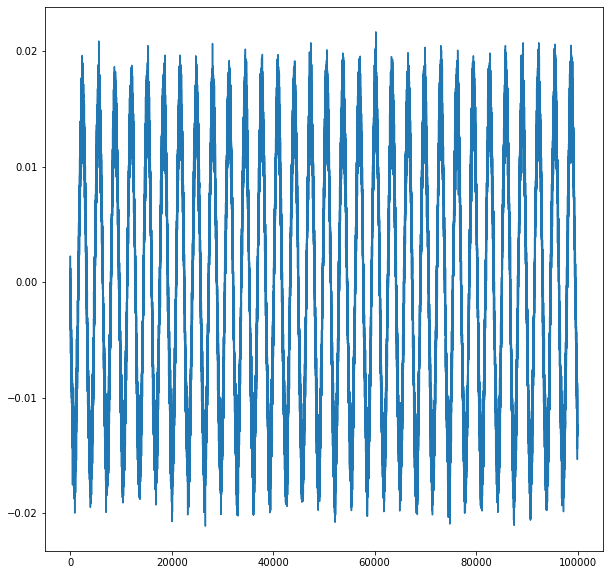

In [3]:
plt.figure(figsize=(10,10))
plt.plot(r)

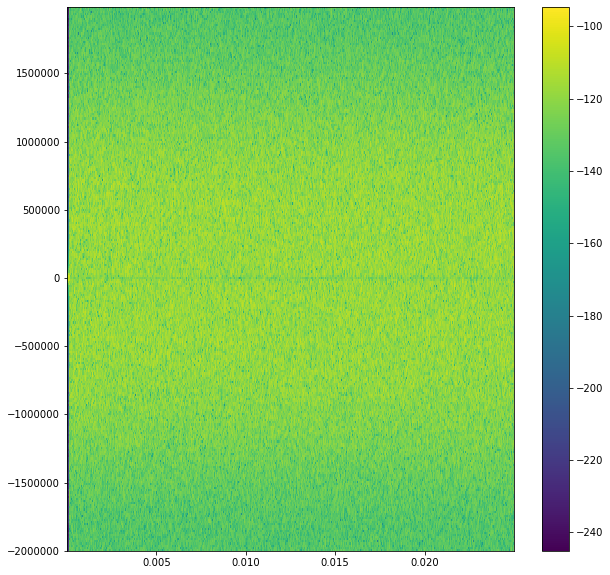

In [4]:
sigband = 20e3            # DC offset bandwidth
cutoff =    (fs-sigband)/fs
b = signal.firwin(  int( 2**10 ) +1, cutoff  )   #ideal lowpass FIR rectangular filter
freqshift = 0.5                     # convert to high pass
arb= np.arange(len(b) )
b  = b * np.exp(1j*2*np.pi* arb *  freqshift )
r  = signal.lfilter(b , 1, r   )
filterdelay = int ( ( (len(b )-1)/(2*fs) ) /(1/fs) )
# r  = r [ filterdelay :  ]
plt.figure( figsize=(10,10) )
plt.specgram(r,Fs= fs)
plt.colorbar()

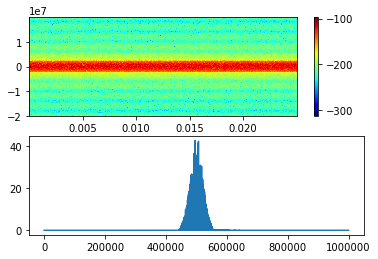

In [5]:
Nfd = 100
fdmax =  5e3   #   5e3  maximum Doppler shift caused by the satellite motion is about 5 kHz   for a stationary receiver'
ov = 10
fs= ov* fs
r = signal.resample_poly( r  , ov * len(r) ,len(r) )
#r = signal.resample( r  , ov * len(r) )

plt.figure(  )
plt.subplot(211)
plt.specgram(r,Fs= fs , cmap= 'jet')
plt.colorbar()
plt.subplot(212)
plt.plot(abs(np.fft.fftshift(np.fft.fft(r))))

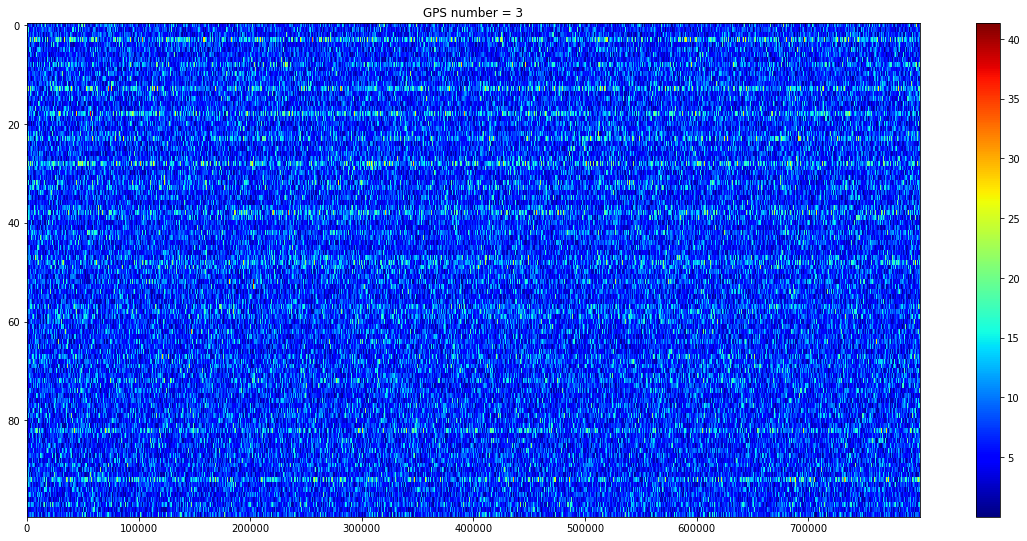

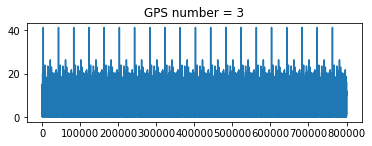

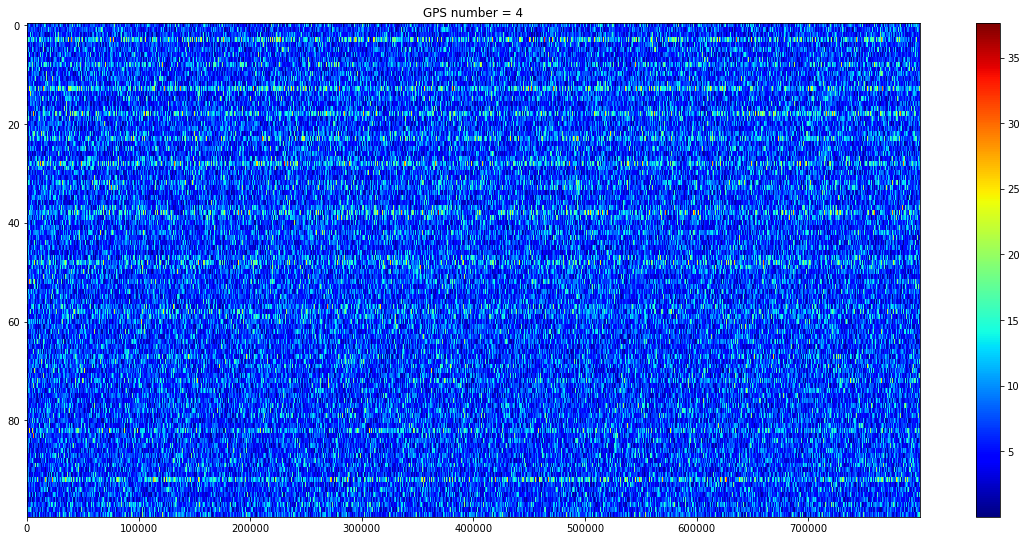

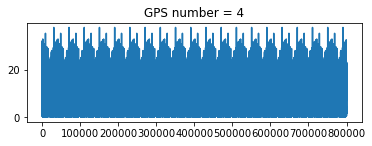

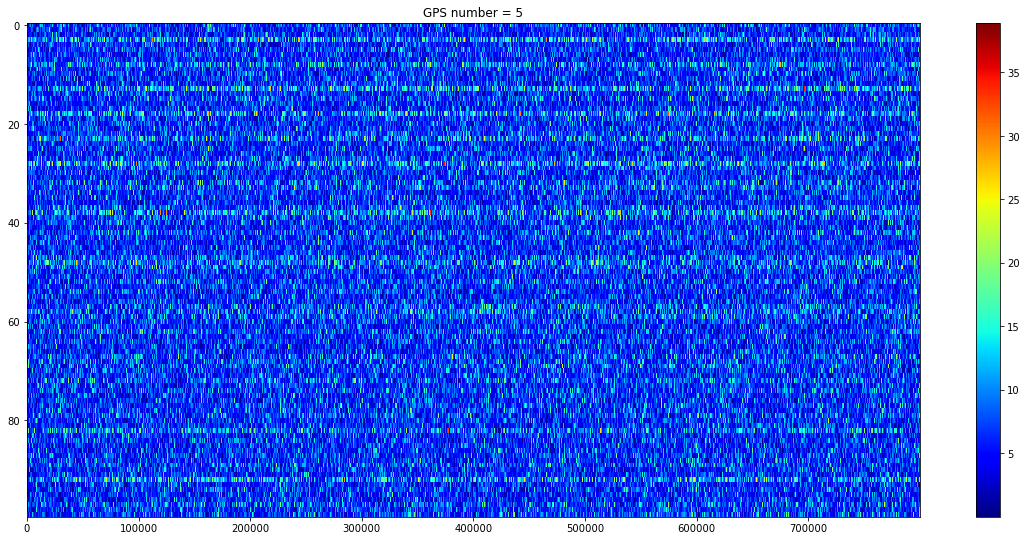

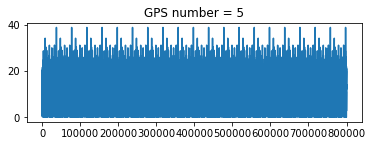

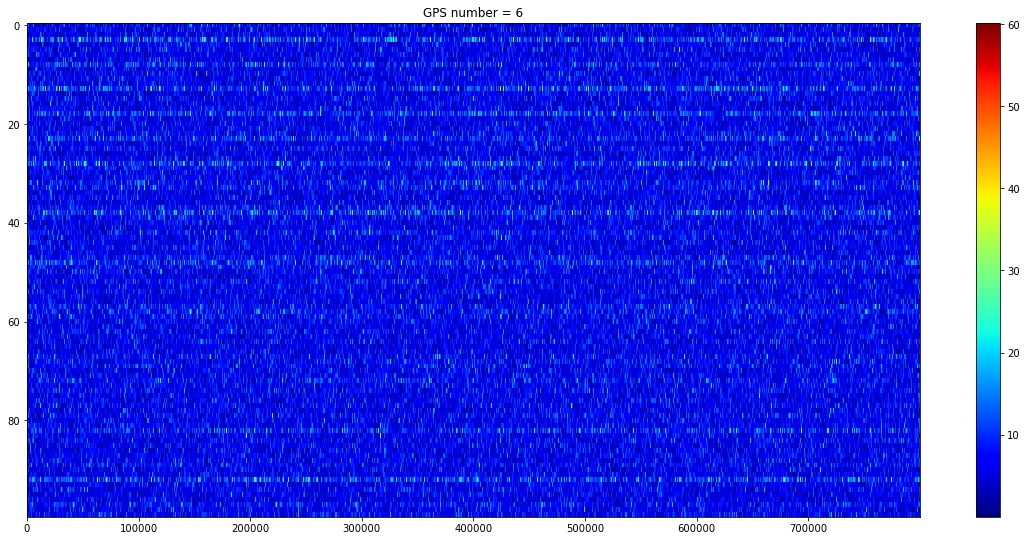

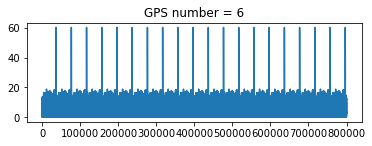

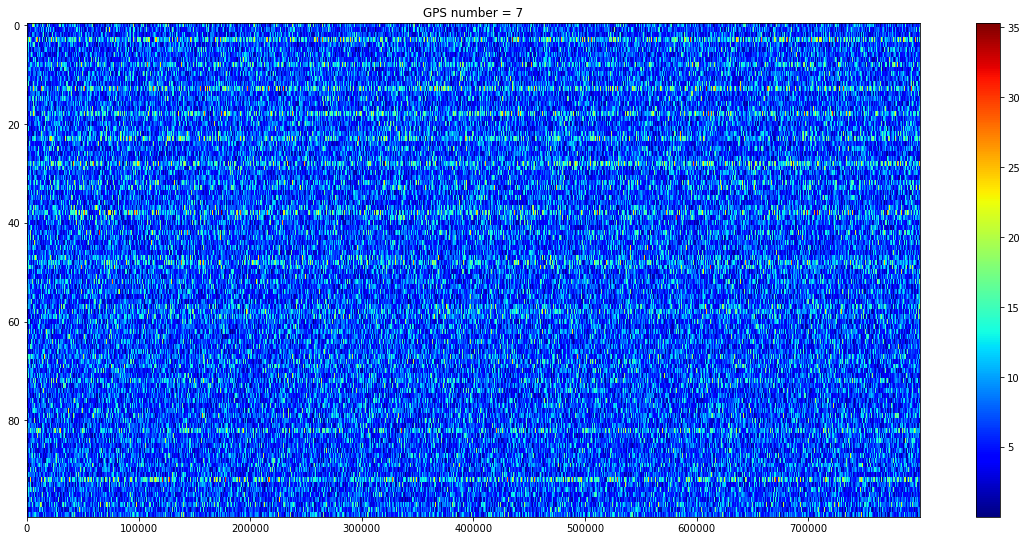

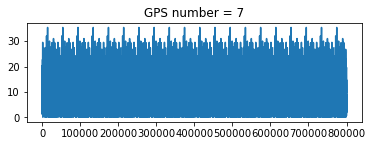

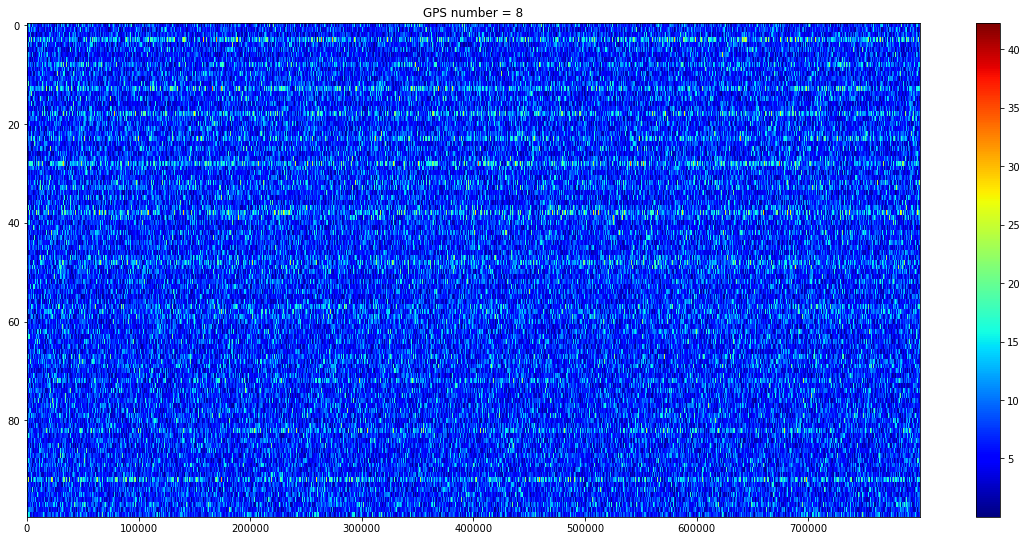

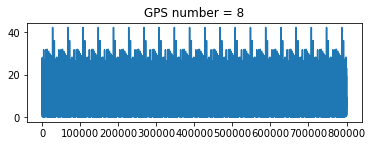

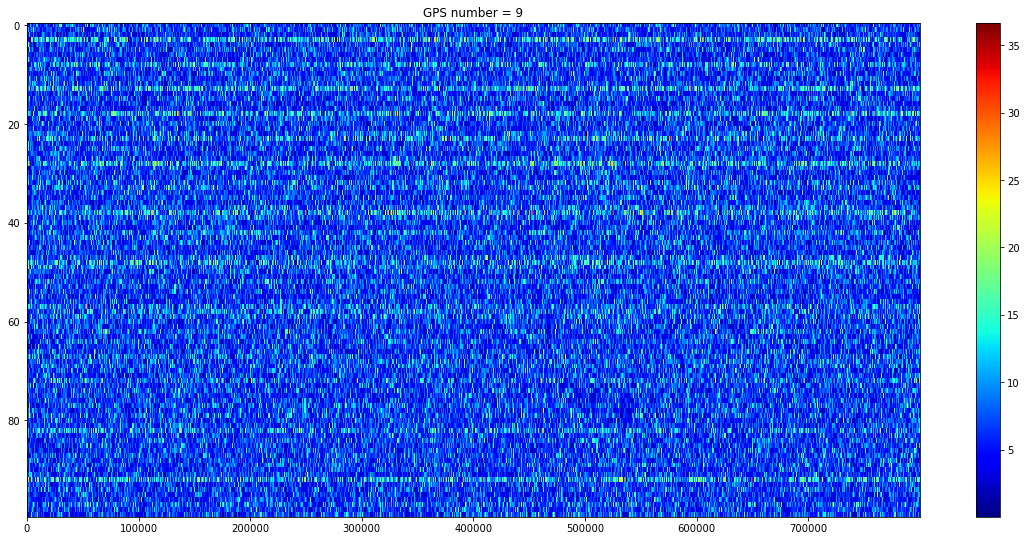

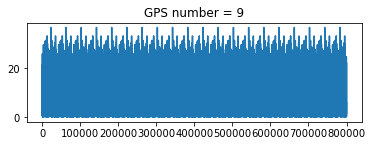

In [6]:



fd = np.linspace(-1,1,Nfd)* (fdmax/fs)



for isat in range( 3 ,  10 ):
    sat = np.array(   PRN(isat) )
    repeatno= 20
    # satr = signal.resample(sat , int((fs/fsca)* len(sat)) )
    # csat = np.tile(satr,repeatno)

    # satt = np.tile(sat,repeatno)
    # csat = signal.resample(satt, int((fs/fsca)* len(satt)) )
    # csat[csat>0]=1
    # csat[csat<0]=-1

    # satind  =  np.floor(np.arange(0,len(sat) , fsca/fs)).astype(int)

    satind  =  np.floor( np.linspace(0, len(sat)-1, num=int((fs/fsca)* len(sat)) )     ).astype(int)
    satrep  = sat[satind]
    csat = np.tile(satrep,repeatno)

    if  len(csat)  >  len(r) :
        csat = csat[0:len(r)]

    rc = r[0:len(csat)]
    t = np.arange(0,len(rc) )

    rr = rc[None,:]*np.exp(-1j*2*np.pi*t[None,:]*fd[:,None])
    YE = np.fft.fft(rr,axis= 1)

    CSAT = np.fft.fft(csat)

    U = np.fft.ifft(YE* np.conj(CSAT[None,:]),axis= 1)

    plt.figure('GPS number = ' + str(isat),figsize=(20,20))
    plt.subplot(211)
    plt.title('GPS number = ' + str(isat))
    plt.imshow(np.abs(U)     ,cmap='jet') #  , vmin =  0 ,  vmax= 30
    plt.axis('auto')
    plt.colorbar()
    plt.show()


    plt.subplot(212)
    plt.title('GPS number = ' + str(isat)  )
    plt.plot(      abs(U)[np.where(np.abs(U)== np.max(np.abs(U)))[0][0]    ]    )
    plt.show()
    ind,  peaks = sig.find_peaks(  abs(U)[np.where(np.abs(U)== np.max(np.abs(U)))[0][0]    ]   , distance=  0.9*  len(satrep) ,  height= 0.1*np.max(np.abs(U)) )
